# Overfitting: Regularization (Weight Decay)
---

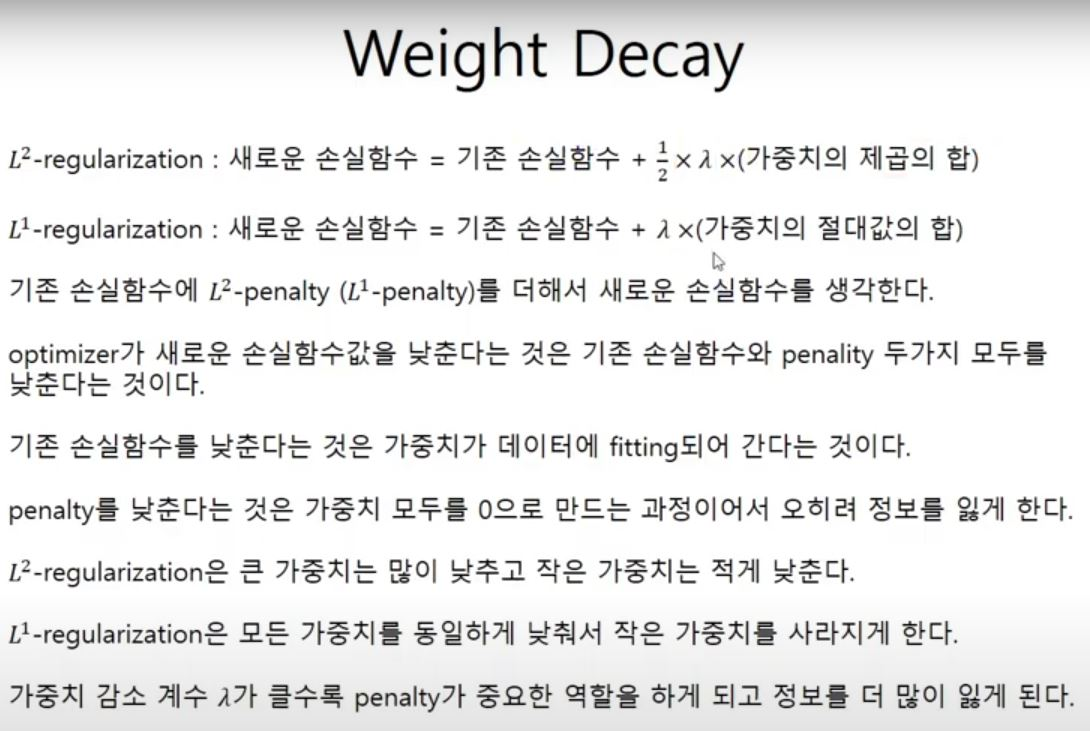
<br>
The reason why the $L^{2}$-Regularization reduces bigger weights much while it decreases smaller ones less and the $L^{1}$-Regularization does equivalently can be explained by contours of loss functions.

Regularization (Weight Decay) and Test Performance

In [1]:
import numpy as np
from collections import OrderedDict
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
# necessary functions and classes
class SGD:
    """
    stochastic gradient descent
    lr: learning rate hyperparameter
    """
    
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

class Momentum:
    """
    Momentum SGD
    lr: learning rate hyperparameter (eta in the above)
    momentum: momentum hyperparameter (alpha in the above)
    """
    
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                # initial momentum -> 0
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

class Nesterov:
    """
    Nesterov's Accelerated Gradient
    More aggressive than Momentum optimizer
    However, the backpropagation process needs to be modified
    to implement NAG. See the formula, f, above.
    This is the reason why it can hardly be applied to deep learning.
    Instead, we can use Bengio's approximation like below.
    lr: learning rate hyperparameter (eta in the above)
    momentum: momentum hyperparameter (alpha in the above)
    """
    
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]

class AdaGrad:
    """
    AdaGrad Optimizer
    lr: a learning rate component (eta in the above)
    self.h: inversely related to lr
    """
    def __init__(self, lr = 0.01):
        self.lr = lr # eta in the above
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key] # Hadamard product
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + 1e-7))
            
class RMSProp:
    """
    RMSProp Optimizer
    lr: learning rate hyperparameter (eta in the above)
    gamma: decaying rate hyperparameter (gamma in the above)
    """
    def __init__(self, lr = 0.01, gamma = 0.99):
        self.lr = lr
        self.gamma = gamma
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] = self.gamma * self.h[key] \
            + (1- self.gamma) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + 1e-7))
            
class Adam:
    """
    Adam Optimizer
    lr: a learning rate component (eta in the above)
    beta1: a hyperparameter for the Momentum Part
    beta2: a hyperparameter for the RMSProp Part (varying learning rate)
    """
    
    def __init__(self, lr = 0.001, beta1 = 0.9, beta2 = 0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
                
        self.iter += 1
        # modified learning rate (to replace m and v with m_hat and v_hat)
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / \
            (1.0 - self.beta1**self.iter)
        for key in params.keys():
            # Update the Momentum hyperparameter.
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            # Update the RMSProp hyperparameter.
            # Hadamard product can be easily implemented via NumPy operations.
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis = 0)
        y = np.exp(x) / np.sum(np.exp(x), axis = 0)
        
        return y.T 

    x = x - np.max(x) # preventing overflow
    
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # Convert into groundtruth labels if training data are one-hot encoded.
    if t.size == y.size:
        t = t.argmax(axis = 1)
             
    batch_size = y.shape[0]
    
    return -np.sum(np.log(
        y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # gradients
        self.dW = None
        self.db = None

    def forward(self, x):
        # for tensor operations
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        
        # for tensor operations
        dx = dx.reshape(*self.original_x_shape)
        
        return dx

class SoftMaxWithLoss:
    def __init__(self):
        self.loss = None # loss function
        self.y = None    # SoftMax output
        self.t = None    # groundtruth (one-hot encoded)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # if one-hot encoded groundtruth
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags = ['multi_index'], op_flags = ['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x + h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x - h)
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        
        x[idx] = tmp_val # Restore values.
        it.iternext()   
        
    return grad
    
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask    

class MultiLayerNetExtend:
    """ Fully Connected Layer
    Parameters
    ----------
    input_size : 784 if MNIST
    hidden_size_list : the number of neurons in a hidden layer（e.g. [100, 100, 100]）
    output_size : 10 if MNIST
    activation : 'ReLU' or 'Sigmoid'
    weight_init_std : e.g. 0.01
        'ReLU' or 'He' -> Set He Initialization.
        'Sigmoid' or 'Xavier' -> Set Xavier Initialization.
    weight_decay_lambda : regularization parameter
    use_dropout : True or False
    dropout_ratio : Dropout Ratio
    use_batchNorm : True or False
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation = 'ReLU', weight_init_std = 'ReLU',
                 weight_decay_lambda = 0, use_dropout = False,
                 dropout_ratio = 0.5, use_batchnorm = False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # weight initialization
        self.__init_weight(weight_init_std)

        # the order of layers: Affine + Batch Norm + Activation + Dropout
        # creating hidden layers (Affine + activation per hidden layer)
        activation_layer = {'Sigmoid': Sigmoid, 'ReLU': ReLU}
        self.layers = OrderedDict()
        
        # input layer and hidden layers
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(
                self.params['W' + str(idx)],
                self.params['b' + str(idx)])
            
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(
                    hidden_size_list[idx -1])
                self.params['beta' + str(idx)] = np.zeros(
                    hidden_size_list[idx - 1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(
                    self.params['gamma' + str(idx)],
                    self.params['beta' + str(idx)])
            
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)

        # the output layer's Affine
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(
            self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        # cross entropy (not SoftMax function)
        self.last_layer = SoftMaxWithLoss()

    def __init_weight(self, weight_init_std):
        """
        Weight Initialization Parameters
        ----------
        weight_init_std : e.g. 0.01
            'ReLU' or 'He' -> Set He Initialization.
            'Sigmoid' or 'Xavier' -> Set Xavier Initialization.
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        # range: We do not need to consider the output layer's
        # weight initialization.
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                # recommended if ReLU
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                # recommended if Sigmoid
                scale = np.sqrt(1.0 / all_size_list[idx - 1])
            self.params['W' + str(idx)] = scale * np.random.randn(
                all_size_list[idx - 1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg = False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                # You need to additionally apply a SoftMax function
                # to get predicted values.
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg = False):
        y = self.predict(x, train_flg)

        weight_decay = 0
        # self.hidden_layer_num + 2: hidden layers
        # + (input layer + output layer)
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda *\
            np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x, train_flg = False)
        y = np.argmax(y, axis = 1)
        # unless one-hot encoded groundtruth
        # ex) one-hot encoded: t = [[0, 0, 1, 0, ..., 0],
        #                           [1, 0, 0, 0, ..., 0],
        #                           [0, 1, 0, 0, ..., 0]] -> t.ndim = 2
        # ex) not one-hot encoded: t = [2, 0, 1] -> t.ndim = 1
        if t.ndim != 1: t = np.argmax(t, axis = 1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t, train_flg = True)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = numerical_gradient(
                loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(
                loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads['gamma' + str(idx)] = numerical_gradient(
                    loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(
                    loss_W, self.params['beta' + str(idx)])

        return grads

    # back propagation
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg = True)
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # Store results.
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            # L2-Regularization assumed (differentiated by weights)
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW +\
            self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
            
            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

In [3]:
# input data
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = (x_train - 0.0) / (255.0 - 0.0)
# 300: to intentionally cause an overfitting problem (too small data)
x_train = x_train[:300].reshape(300, -1)
t_train = t_train[:300]
x_test = (x_test - 0.0) / (255.0 - 0.0)
x_test = x_test.reshape(-1, 784)

weight_decay_lambda = 0.1

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

In [4]:
weight_decay_lambda = 0.1

In [5]:
network = MultiLayerNetExtend(input_size = 784,
                              hidden_size_list = [100, 100, 100, 100, 100, 100],
                              output_size = 10,
                              weight_decay_lambda = weight_decay_lambda)
optimizer = SGD(lr = learning_rate)

In [6]:
training_loss_list = []
training_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        training_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        training_acc_list.append(training_acc)
        test_acc_list.append(test_acc)
        
        print("Epoch: " + str(epoch_cnt + 1) + ", Training Acc: " +\
              str(training_acc) + ", Test Acc: " + str(test_acc))
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

Epoch: 1, Training Acc: 0.14, Test Acc: 0.1337
Epoch: 2, Training Acc: 0.16666666666666666, Test Acc: 0.1503
Epoch: 3, Training Acc: 0.24333333333333335, Test Acc: 0.1794
Epoch: 4, Training Acc: 0.27, Test Acc: 0.1952
Epoch: 5, Training Acc: 0.2833333333333333, Test Acc: 0.225
Epoch: 6, Training Acc: 0.3333333333333333, Test Acc: 0.2429
Epoch: 7, Training Acc: 0.35333333333333333, Test Acc: 0.258
Epoch: 8, Training Acc: 0.38666666666666666, Test Acc: 0.2759
Epoch: 9, Training Acc: 0.41, Test Acc: 0.2903
Epoch: 10, Training Acc: 0.42333333333333334, Test Acc: 0.3031
Epoch: 11, Training Acc: 0.4266666666666667, Test Acc: 0.3119
Epoch: 12, Training Acc: 0.44666666666666666, Test Acc: 0.3247
Epoch: 13, Training Acc: 0.45666666666666667, Test Acc: 0.3365
Epoch: 14, Training Acc: 0.47333333333333333, Test Acc: 0.344
Epoch: 15, Training Acc: 0.5066666666666667, Test Acc: 0.3484
Epoch: 16, Training Acc: 0.5233333333333333, Test Acc: 0.3628
Epoch: 17, Training Acc: 0.56, Test Acc: 0.3691
Epoch:

Epoch: 147, Training Acc: 0.91, Test Acc: 0.7268
Epoch: 148, Training Acc: 0.92, Test Acc: 0.7368
Epoch: 149, Training Acc: 0.9166666666666666, Test Acc: 0.7313
Epoch: 150, Training Acc: 0.9166666666666666, Test Acc: 0.7291
Epoch: 151, Training Acc: 0.9266666666666666, Test Acc: 0.7361
Epoch: 152, Training Acc: 0.9166666666666666, Test Acc: 0.7376
Epoch: 153, Training Acc: 0.9166666666666666, Test Acc: 0.7336
Epoch: 154, Training Acc: 0.9133333333333333, Test Acc: 0.7344
Epoch: 155, Training Acc: 0.9166666666666666, Test Acc: 0.7235
Epoch: 156, Training Acc: 0.92, Test Acc: 0.7359
Epoch: 157, Training Acc: 0.92, Test Acc: 0.7317
Epoch: 158, Training Acc: 0.9233333333333333, Test Acc: 0.7361
Epoch: 159, Training Acc: 0.92, Test Acc: 0.7343
Epoch: 160, Training Acc: 0.92, Test Acc: 0.7304
Epoch: 161, Training Acc: 0.92, Test Acc: 0.7328
Epoch: 162, Training Acc: 0.9166666666666666, Test Acc: 0.734
Epoch: 163, Training Acc: 0.9233333333333333, Test Acc: 0.7372
Epoch: 164, Training Acc: 0.

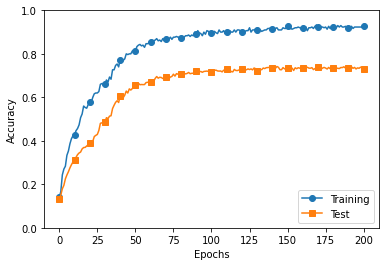

In [7]:
markers = {'training': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, training_acc_list, marker = 'o', label = 'Training',
         markevery = 10)
plt.plot(x, test_acc_list, marker = 's', label = 'Test',
         markevery = 10)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc = 'lower right')
plt.show()

What if we do not apply `Weight Decay`?

In [8]:
network = MultiLayerNetExtend(input_size = 784,
                              hidden_size_list = [100, 100, 100, 100, 100, 100],
                              output_size = 10,
                              weight_decay_lambda = 0)
optimizer = SGD(lr = learning_rate)

In [9]:
training_loss_list = []
training_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        training_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        training_acc_list.append(training_acc)
        test_acc_list.append(test_acc)
        
        print("Epoch: " + str(epoch_cnt + 1) + ", Training Acc: " +\
              str(training_acc) + ", Test Acc: " + str(test_acc))
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

Epoch: 1, Training Acc: 0.12666666666666668, Test Acc: 0.107
Epoch: 2, Training Acc: 0.14, Test Acc: 0.1146
Epoch: 3, Training Acc: 0.14333333333333334, Test Acc: 0.121
Epoch: 4, Training Acc: 0.15, Test Acc: 0.1251
Epoch: 5, Training Acc: 0.15333333333333332, Test Acc: 0.1306
Epoch: 6, Training Acc: 0.16333333333333333, Test Acc: 0.139
Epoch: 7, Training Acc: 0.18333333333333332, Test Acc: 0.145
Epoch: 8, Training Acc: 0.2, Test Acc: 0.1533
Epoch: 9, Training Acc: 0.23333333333333334, Test Acc: 0.1653
Epoch: 10, Training Acc: 0.25, Test Acc: 0.175
Epoch: 11, Training Acc: 0.29333333333333333, Test Acc: 0.1983
Epoch: 12, Training Acc: 0.31333333333333335, Test Acc: 0.2088
Epoch: 13, Training Acc: 0.36666666666666664, Test Acc: 0.2259
Epoch: 14, Training Acc: 0.36666666666666664, Test Acc: 0.2372
Epoch: 15, Training Acc: 0.4033333333333333, Test Acc: 0.2546
Epoch: 16, Training Acc: 0.43666666666666665, Test Acc: 0.2684
Epoch: 17, Training Acc: 0.4533333333333333, Test Acc: 0.2782
Epoch:

Epoch: 147, Training Acc: 1.0, Test Acc: 0.7554
Epoch: 148, Training Acc: 1.0, Test Acc: 0.757
Epoch: 149, Training Acc: 1.0, Test Acc: 0.7549
Epoch: 150, Training Acc: 1.0, Test Acc: 0.7565
Epoch: 151, Training Acc: 1.0, Test Acc: 0.7549
Epoch: 152, Training Acc: 1.0, Test Acc: 0.7544
Epoch: 153, Training Acc: 1.0, Test Acc: 0.7596
Epoch: 154, Training Acc: 1.0, Test Acc: 0.7589
Epoch: 155, Training Acc: 1.0, Test Acc: 0.7596
Epoch: 156, Training Acc: 1.0, Test Acc: 0.7575
Epoch: 157, Training Acc: 1.0, Test Acc: 0.7529
Epoch: 158, Training Acc: 1.0, Test Acc: 0.7573
Epoch: 159, Training Acc: 1.0, Test Acc: 0.7584
Epoch: 160, Training Acc: 1.0, Test Acc: 0.7619
Epoch: 161, Training Acc: 1.0, Test Acc: 0.7586
Epoch: 162, Training Acc: 1.0, Test Acc: 0.7583
Epoch: 163, Training Acc: 1.0, Test Acc: 0.757
Epoch: 164, Training Acc: 1.0, Test Acc: 0.7595
Epoch: 165, Training Acc: 1.0, Test Acc: 0.7591
Epoch: 166, Training Acc: 1.0, Test Acc: 0.7603
Epoch: 167, Training Acc: 1.0, Test Acc: 0

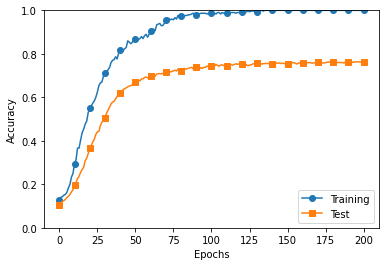

In [10]:
markers = {'training': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, training_acc_list, marker = 'o', label = 'Training',
         markevery = 10)
plt.plot(x, test_acc_list, marker = 's', label = 'Test',
         markevery = 10)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc = 'lower right')
plt.show()

# Overfitting: Dropout
---

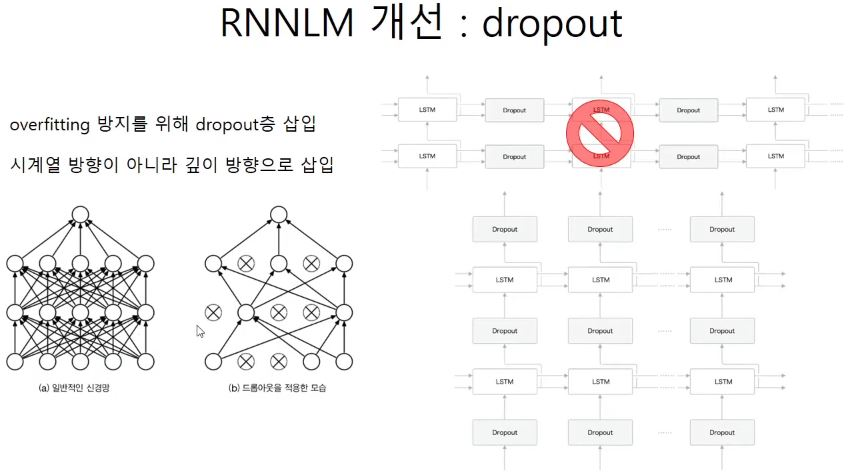
<br>
Underlying Basic Philosophy: Ensemble!

Dropout and Test Performance

In [11]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio) # rescaling

    def backward(self, dout):
        return dout * self.mask

In [12]:
class Trainer:
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs = 20, mini_batch_size = 100,
                 optimizer = 'SGD', optimizer_param = {'lr': 0.01}, 
                 evaluate_sample_num_per_epoch = None, verbose = True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd': SGD, 'momentum': Momentum,
                                'nesterov': Nesterov, 'adagrad': AdaGrad,
                                'rmsprpo': RMSProp, 'adam': Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("Training Loss: " + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== Epoch: " + str(self.current_epoch) +\
                                   ", Training Acc: " + str(train_acc) +\
                                   ", Test Acc: " + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("Test Acc: " + str(test_acc))

In [13]:
# input data
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = (x_train - 0.0) / (255.0 - 0.0)
# 300: to intentionally cause an overfitting problem (too small data)
x_train = x_train[:300].reshape(300, -1)
t_train = t_train[:300]
x_test = (x_test - 0.0) / (255.0 - 0.0)
x_test = x_test.reshape(-1, 784)

In [14]:
use_dropout = True
dropout_ratio = 0.2

In [15]:
network = MultiLayerNetExtend(input_size = 784,
                              hidden_size_list = [100, 100, 100, 100, 100, 100],
                              output_size = 10,
                              use_dropout = use_dropout,
                              dropout_ratio = dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs = 301, mini_batch_size = 100,
                  optimizer = 'sgd', optimizer_param = {'lr': 0.01},
                  verbose = True)
trainer.train()

training_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

Training Loss: 2.3059496061489244
=== Epoch: 1, Training Acc: 0.12, Test Acc: 0.1466 ===
Training Loss: 2.3222772204099407
Training Loss: 2.3404996263200792
Training Loss: 2.3126576975458413
=== Epoch: 2, Training Acc: 0.12666666666666668, Test Acc: 0.1496 ===
Training Loss: 2.3059593676972874
Training Loss: 2.3110386179212448
Training Loss: 2.3071153658480514
=== Epoch: 3, Training Acc: 0.13666666666666666, Test Acc: 0.149 ===
Training Loss: 2.3096683632316304
Training Loss: 2.3017179943462507
Training Loss: 2.285659402631779
=== Epoch: 4, Training Acc: 0.15, Test Acc: 0.1494 ===
Training Loss: 2.3299303615216234
Training Loss: 2.293354380699214
Training Loss: 2.310631348251669
=== Epoch: 5, Training Acc: 0.15, Test Acc: 0.1484 ===
Training Loss: 2.29684584932899
Training Loss: 2.2929762484566614
Training Loss: 2.288123072391768
=== Epoch: 6, Training Acc: 0.15333333333333332, Test Acc: 0.1483 ===
Training Loss: 2.304029671078004
Training Loss: 2.320512689442462
Training Loss: 2.28340

=== Epoch: 51, Training Acc: 0.31333333333333335, Test Acc: 0.2409 ===
Training Loss: 2.2364008101469097
Training Loss: 2.240313946673692
Training Loss: 2.23599651344551
=== Epoch: 52, Training Acc: 0.31666666666666665, Test Acc: 0.2393 ===
Training Loss: 2.232166352662679
Training Loss: 2.2440589959533623
Training Loss: 2.2373775466520938
=== Epoch: 53, Training Acc: 0.31, Test Acc: 0.2374 ===
Training Loss: 2.238005810444397
Training Loss: 2.245784443413891
Training Loss: 2.2423416154381255
=== Epoch: 54, Training Acc: 0.3, Test Acc: 0.2354 ===
Training Loss: 2.2214616792457313
Training Loss: 2.2208869844274086
Training Loss: 2.253313940409931
=== Epoch: 55, Training Acc: 0.29333333333333333, Test Acc: 0.2361 ===
Training Loss: 2.24452194331745
Training Loss: 2.2208292548131148
Training Loss: 2.231761894872054
=== Epoch: 56, Training Acc: 0.2966666666666667, Test Acc: 0.2386 ===
Training Loss: 2.2457993646441725
Training Loss: 2.2366603524535678
Training Loss: 2.2078601764798993
=== 

Training Loss: 2.090108591877521
Training Loss: 2.1502484083352
=== Epoch: 102, Training Acc: 0.31, Test Acc: 0.23 ===
Training Loss: 2.1531326270699456
Training Loss: 2.1181929964500856
Training Loss: 2.0905641229842082
=== Epoch: 103, Training Acc: 0.30666666666666664, Test Acc: 0.2272 ===
Training Loss: 2.143038509574513
Training Loss: 2.139909132105754
Training Loss: 2.153676682961919
=== Epoch: 104, Training Acc: 0.31, Test Acc: 0.2362 ===
Training Loss: 2.100496548551989
Training Loss: 2.1484134669349286
Training Loss: 2.0931755133572763
=== Epoch: 105, Training Acc: 0.31666666666666665, Test Acc: 0.2378 ===
Training Loss: 2.1411130303988237
Training Loss: 2.179825275397166
Training Loss: 2.084151595362436
=== Epoch: 106, Training Acc: 0.31, Test Acc: 0.2349 ===
Training Loss: 2.0891456687176073
Training Loss: 2.157383813130752
Training Loss: 2.0923998562128094
=== Epoch: 107, Training Acc: 0.30333333333333334, Test Acc: 0.2323 ===
Training Loss: 2.043577291110985
Training Loss: 

Training Loss: 1.9072798120617216
=== Epoch: 151, Training Acc: 0.41, Test Acc: 0.3103 ===
Training Loss: 1.9462177738356663
Training Loss: 1.9582274343631454
Training Loss: 1.958192019008687
=== Epoch: 152, Training Acc: 0.41333333333333333, Test Acc: 0.315 ===
Training Loss: 1.9616267173056943
Training Loss: 2.0281232768708426
Training Loss: 1.921090352228819
=== Epoch: 153, Training Acc: 0.42333333333333334, Test Acc: 0.3206 ===
Training Loss: 1.882204036969802
Training Loss: 1.9726939011069686
Training Loss: 1.9392042361604174
=== Epoch: 154, Training Acc: 0.43, Test Acc: 0.3256 ===
Training Loss: 1.919169750288949
Training Loss: 1.8907932890415606
Training Loss: 1.9696279069624976
=== Epoch: 155, Training Acc: 0.43, Test Acc: 0.3211 ===
Training Loss: 2.0124129584129724
Training Loss: 1.9193891995556294
Training Loss: 2.026836369044217
=== Epoch: 156, Training Acc: 0.42333333333333334, Test Acc: 0.3242 ===
Training Loss: 1.91426180886442
Training Loss: 2.090072001595928
Training L

Training Loss: 1.6167721253934266
Training Loss: 1.6690618030180757
=== Epoch: 201, Training Acc: 0.56, Test Acc: 0.4171 ===
Training Loss: 1.6829703263613016
Training Loss: 1.7056015749815392
Training Loss: 1.5960583463489832
=== Epoch: 202, Training Acc: 0.5666666666666667, Test Acc: 0.4163 ===
Training Loss: 1.6713381825982276
Training Loss: 1.7564543227551968
Training Loss: 1.69502624968318
=== Epoch: 203, Training Acc: 0.5666666666666667, Test Acc: 0.4222 ===
Training Loss: 1.7721462391236997
Training Loss: 1.615195334231757
Training Loss: 1.6771746317007798
=== Epoch: 204, Training Acc: 0.57, Test Acc: 0.4242 ===
Training Loss: 1.633071526445886
Training Loss: 1.6501280429426572
Training Loss: 1.636058686873557
=== Epoch: 205, Training Acc: 0.5766666666666667, Test Acc: 0.4298 ===
Training Loss: 1.628306374895615
Training Loss: 1.5780952454269428
Training Loss: 1.6118087534148386
=== Epoch: 206, Training Acc: 0.5766666666666667, Test Acc: 0.4317 ===
Training Loss: 1.6570572878321

Training Loss: 1.3082744407150324
Training Loss: 1.2820845320357037
=== Epoch: 251, Training Acc: 0.7233333333333334, Test Acc: 0.5463 ===
Training Loss: 1.2454972311437478
Training Loss: 1.4220103922743244
Training Loss: 1.2717704042554219
=== Epoch: 252, Training Acc: 0.7266666666666667, Test Acc: 0.5505 ===
Training Loss: 1.3538727949570366
Training Loss: 1.2110915843493728
Training Loss: 1.3759878667049332
=== Epoch: 253, Training Acc: 0.7266666666666667, Test Acc: 0.5536 ===
Training Loss: 1.3492431566107088
Training Loss: 1.3021372294908693
Training Loss: 1.1896691165003612
=== Epoch: 254, Training Acc: 0.73, Test Acc: 0.5572 ===
Training Loss: 1.2537595071061112
Training Loss: 1.3092488668068507
Training Loss: 1.2081082224181654
=== Epoch: 255, Training Acc: 0.73, Test Acc: 0.5589 ===
Training Loss: 1.218378135358581
Training Loss: 1.2393540044886
Training Loss: 1.2914892717307211
=== Epoch: 256, Training Acc: 0.7366666666666667, Test Acc: 0.5596 ===
Training Loss: 1.26514101766

Training Loss: 0.8813752748891571
Training Loss: 0.9144631241052639
=== Epoch: 300, Training Acc: 0.74, Test Acc: 0.5949 ===
Training Loss: 0.9249744766055297
Training Loss: 0.8969720147383734
Training Loss: 0.9516778210923347
=== Epoch: 301, Training Acc: 0.7366666666666667, Test Acc: 0.5966 ===
Training Loss: 1.0629562191417439
Training Loss: 0.8379650969709079
=============== Final Test Accuracy ===============
Test Acc: 0.5987


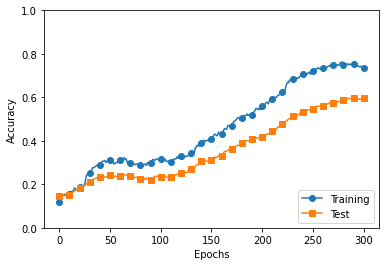

In [16]:
# graph
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(training_acc_list))
plt.plot(x, training_acc_list, marker = 'o', label = 'Training',
         markevery = 10)
plt.plot(x, test_acc_list, marker = 's', label = 'Test',
         markevery = 10)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc = 'lower right')
plt.show()

What if we do not apply `Dropout`?

In [17]:
network = MultiLayerNetExtend(input_size = 784,
                              hidden_size_list = [100, 100, 100, 100, 100, 100],
                              output_size = 10,
                              use_dropout = False,
                              dropout_ratio = 0)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs = 301, mini_batch_size = 100,
                  optimizer = 'sgd', optimizer_param = {'lr': 0.01},
                  verbose = True)
trainer.train()

training_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

Training Loss: 2.3445065897455315
=== Epoch: 1, Training Acc: 0.08333333333333333, Test Acc: 0.0975 ===
Training Loss: 2.3019251740188498
Training Loss: 2.2888563482161914
Training Loss: 2.353469514164698
=== Epoch: 2, Training Acc: 0.10333333333333333, Test Acc: 0.106 ===
Training Loss: 2.3441922570452682
Training Loss: 2.3289929239280136
Training Loss: 2.3063878790969614
=== Epoch: 3, Training Acc: 0.11333333333333333, Test Acc: 0.1074 ===
Training Loss: 2.300989396999485
Training Loss: 2.2701714065183656
Training Loss: 2.2730755288448985
=== Epoch: 4, Training Acc: 0.12, Test Acc: 0.1161 ===
Training Loss: 2.269149811792621
Training Loss: 2.261925594490369
Training Loss: 2.2491326479973512
=== Epoch: 5, Training Acc: 0.14333333333333334, Test Acc: 0.1231 ===
Training Loss: 2.200874297250989
Training Loss: 2.2364869060161094
Training Loss: 2.2614709897809764
=== Epoch: 6, Training Acc: 0.17333333333333334, Test Acc: 0.1318 ===
Training Loss: 2.188739680978837
Training Loss: 2.1553927

Training Loss: 0.7835926340834043
=== Epoch: 52, Training Acc: 0.8433333333333334, Test Acc: 0.6288 ===
Training Loss: 0.7268426800299299
Training Loss: 0.6778702437551689
Training Loss: 0.7194865659273553
=== Epoch: 53, Training Acc: 0.8533333333333334, Test Acc: 0.6383 ===
Training Loss: 0.6723480525382315
Training Loss: 0.6572404964820122
Training Loss: 0.6551395968467524
=== Epoch: 54, Training Acc: 0.8566666666666667, Test Acc: 0.6438 ===
Training Loss: 0.6116829517766829
Training Loss: 0.5917077248425874
Training Loss: 0.689792800999229
=== Epoch: 55, Training Acc: 0.85, Test Acc: 0.6427 ===
Training Loss: 0.5685134907510762
Training Loss: 0.5709071257843938
Training Loss: 0.6238443853838286
=== Epoch: 56, Training Acc: 0.8733333333333333, Test Acc: 0.652 ===
Training Loss: 0.5616169782409055
Training Loss: 0.523610672114225
Training Loss: 0.5643413973359178
=== Epoch: 57, Training Acc: 0.8766666666666667, Test Acc: 0.6525 ===
Training Loss: 0.5018841235584952
Training Loss: 0.56

=== Epoch: 101, Training Acc: 0.9733333333333334, Test Acc: 0.7316 ===
Training Loss: 0.16881687351640184
Training Loss: 0.15574778178063667
Training Loss: 0.16190674487326073
=== Epoch: 102, Training Acc: 0.9733333333333334, Test Acc: 0.7391 ===
Training Loss: 0.16299426093087468
Training Loss: 0.11590834181058779
Training Loss: 0.17638928792311137
=== Epoch: 103, Training Acc: 0.9733333333333334, Test Acc: 0.7392 ===
Training Loss: 0.15551361126353758
Training Loss: 0.1467837418849871
Training Loss: 0.20453270566642767
=== Epoch: 104, Training Acc: 0.9833333333333333, Test Acc: 0.733 ===
Training Loss: 0.15451986622969957
Training Loss: 0.15878679589030364
Training Loss: 0.09827357349831031
=== Epoch: 105, Training Acc: 0.9833333333333333, Test Acc: 0.7348 ===
Training Loss: 0.10664199869453135
Training Loss: 0.15900580582559895
Training Loss: 0.13609242626565698
=== Epoch: 106, Training Acc: 0.9833333333333333, Test Acc: 0.7384 ===
Training Loss: 0.12805748469524272
Training Loss: 0

=== Epoch: 151, Training Acc: 1.0, Test Acc: 0.7538 ===
Training Loss: 0.0566372283759552
Training Loss: 0.04816675279319634
Training Loss: 0.058740711562897056
=== Epoch: 152, Training Acc: 1.0, Test Acc: 0.7531 ===
Training Loss: 0.057117899900872945
Training Loss: 0.042600924042181514
Training Loss: 0.048440558829939334
=== Epoch: 153, Training Acc: 1.0, Test Acc: 0.7532 ===
Training Loss: 0.05457811886991081
Training Loss: 0.045416450507523375
Training Loss: 0.057643751396326603
=== Epoch: 154, Training Acc: 1.0, Test Acc: 0.7529 ===
Training Loss: 0.04242507988817091
Training Loss: 0.06384303788422445
Training Loss: 0.047665083870775685
=== Epoch: 155, Training Acc: 1.0, Test Acc: 0.7531 ===
Training Loss: 0.06063313923890872
Training Loss: 0.0578565894077535
Training Loss: 0.047576911272145354
=== Epoch: 156, Training Acc: 1.0, Test Acc: 0.7528 ===
Training Loss: 0.04083089509623677
Training Loss: 0.03784950381868345
Training Loss: 0.056326319185015475
=== Epoch: 157, Training Ac

Training Loss: 0.021340719662879638
=== Epoch: 202, Training Acc: 1.0, Test Acc: 0.7545 ===
Training Loss: 0.020288008572980538
Training Loss: 0.023776778150770266
Training Loss: 0.02504903252553325
=== Epoch: 203, Training Acc: 1.0, Test Acc: 0.7559 ===
Training Loss: 0.02809351585132486
Training Loss: 0.032931204047046074
Training Loss: 0.02276259509892225
=== Epoch: 204, Training Acc: 1.0, Test Acc: 0.7548 ===
Training Loss: 0.023908711905692836
Training Loss: 0.020574910552210647
Training Loss: 0.024348535024467717
=== Epoch: 205, Training Acc: 1.0, Test Acc: 0.7559 ===
Training Loss: 0.020889771762452367
Training Loss: 0.027033248191822068
Training Loss: 0.024679476424242064
=== Epoch: 206, Training Acc: 1.0, Test Acc: 0.7557 ===
Training Loss: 0.016802381632634082
Training Loss: 0.022344949834468098
Training Loss: 0.016137372386128272
=== Epoch: 207, Training Acc: 1.0, Test Acc: 0.7553 ===
Training Loss: 0.02083966078597639
Training Loss: 0.022167794569916324
Training Loss: 0.022

=== Epoch: 254, Training Acc: 1.0, Test Acc: 0.7568 ===
Training Loss: 0.015147165504286792
Training Loss: 0.0179250510673034
Training Loss: 0.015860827577286508
=== Epoch: 255, Training Acc: 1.0, Test Acc: 0.758 ===
Training Loss: 0.01152116211591804
Training Loss: 0.01420390855069863
Training Loss: 0.013929378518301526
=== Epoch: 256, Training Acc: 1.0, Test Acc: 0.7574 ===
Training Loss: 0.012796999328516126
Training Loss: 0.011219604401514045
Training Loss: 0.013111528748733538
=== Epoch: 257, Training Acc: 1.0, Test Acc: 0.7573 ===
Training Loss: 0.015223021983133123
Training Loss: 0.014771617135776323
Training Loss: 0.011783141447300336
=== Epoch: 258, Training Acc: 1.0, Test Acc: 0.758 ===
Training Loss: 0.013127669599723215
Training Loss: 0.012503491296987565
Training Loss: 0.012164594803533704
=== Epoch: 259, Training Acc: 1.0, Test Acc: 0.7577 ===
Training Loss: 0.010845764193396515
Training Loss: 0.014046423268023195
Training Loss: 0.010467014017821059
=== Epoch: 260, Traini

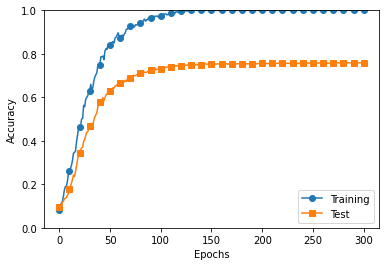

In [18]:
# graph
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(training_acc_list))
plt.plot(x, training_acc_list, marker = 'o', label = 'Training',
         markevery = 10)
plt.plot(x, test_acc_list, marker = 's', label = 'Test',
         markevery = 10)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc = 'lower right')
plt.show()

# Overfitting: Using an Early Stopping Callback Function
---

using TensorFlow 2.0 framework

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 50

In [3]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten() # 28 X 28 = 784
        self.dense1 = tf.keras.layers.Dense(64, activation = 'relu')
        self.dense2 = tf.keras.layers.Dense(64, activation = 'relu')
        self.dense3 = tf.keras.layers.Dense(64, activation = 'relu')
        self.dense4 = tf.keras.layers.Dense(128, activation = 'relu')
        self.dropout4 = tf.keras.layers.Dropout(0.5)
        # the number of categories: 10
        self.dense5 = tf.keras.layers.Dense(10, activation = 'softmax')

    def call(self, x, training=False, mask=None):
        h = self.flatten(x)
        h = self.dense1(h)
        h = self.dense2(h)
        h = self.dense3(h)
        h = self.dense4(h)
        h = self.dropout4(h)
        return self.dense5(h)

In [4]:
# loading data
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32).prefetch(2048)
test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)).batch(32).prefetch(2048)

In [5]:
# instantiating a model
model = MyModel()

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [6]:
# early stopping callback
earlystopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                patience = 10,
                                                verbose = 1)

In [7]:
# training
history = model.fit(train_ds, validation_data = test_ds,
                    epochs = EPOCHS, callbacks = [earlystopper])

Epoch 1/50
1875/1875 [==============================] - 13s 6ms/step - loss: 0.5869 - accuracy: 0.7937 - val_loss: 0.4471 - val_accuracy: 0.8373
Epoch 2/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4141 - accuracy: 0.8532 - val_loss: 0.4178 - val_accuracy: 0.8505
Epoch 3/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3727 - accuracy: 0.8671 - val_loss: 0.4146 - val_accuracy: 0.8515
Epoch 4/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3517 - accuracy: 0.8747 - val_loss: 0.3937 - val_accuracy: 0.8582
Epoch 5/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3358 - accuracy: 0.8800 - val_loss: 0.3694 - val_accuracy: 0.8682
Epoch 6/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3203 - accuracy: 0.8842 - val_loss: 0.3645 - val_accuracy: 0.8703
Epoch 7/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3068 - accuracy: 0.8887 - val_loss: 0.3444 - val_ac

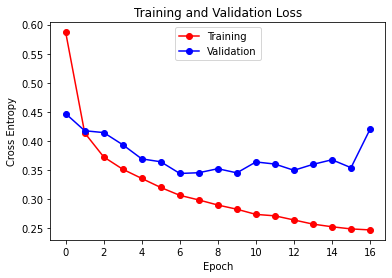

In [9]:
# visualization
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-')
plt.plot(val_loss, 'bo-')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend(['Training', 'Validation'], loc = 'upper center')
plt.show()

Batch Normalization also can contribute to alleviating overfitting problems.

Besides, there are different measures to alleviate overfitting problems such as Invariances, Tangent propagation, and Training with transformed data. Regarding these methods, see C. Bishop (2006).

# Underfitting
---

# Data Augmentation
---